Tested on i7-6800K with GTX 1080

In [1]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm

# Load data

In [2]:
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score


mnist = fetch_mldata('MNIST original', data_home='./tmp')

# only binary classification supported
mask = (mnist['target'] == 3) + (mnist['target'] == 5)

X_all = scale(mnist['data'][mask].astype(float))
y_all = (mnist['target'][mask]==3)*1

# make it more sparse
X_all = X_all * (np.random.uniform(0, 1, X_all.shape) > 0.8)

print('Dataset shape: {}'.format(X_all.shape))
print('Non-zeros rate: {}'.format(np.mean(X_all != 0)))
print('Classes balance: {} / {}'.format(np.mean(y_all==0), np.mean(y_all==1)))

X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, random_state=42, test_size=0.3)

Dataset shape: (13454, 784)
Non-zeros rate: 0.16339869714795388
Classes balance: 0.4692284822357663 / 0.5307715177642337


# Dense data

In [3]:
from tffm import TFFMClassifier

In [7]:
model = TFFMClassifier(
    order=3,
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.01), 
    n_epochs=100, 
    batch_size=-1,
    init_std=0.001,
    reg=0.001,
    input_type='dense',
    session_config=tf.ConfigProto(log_device_placement=True, device_count = {'GPU': 0}),
    seed=42
)
print('CPU only / dense data')
model.fit(X_tr, y_tr, show_progress=True)
predictions = model.predict(X_te)
print('accuracy: {}'.format(accuracy_score(y_te, predictions)))
model.destroy()

CPU only / dense data


100%|██████████| 100/100 [00:20<00:00,  4.77epoch/s]

accuracy: 0.91726529601189


in stderr: main_block/order_2/Pow/y: (Const): /job:localhost/replica:0/task:0/cpu:0

In [8]:
model = TFFMClassifier(
    order=3,
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.01), 
    n_epochs=100, 
    batch_size=-1,
    init_std=0.001,
    reg=0.001,
    input_type='dense',
    session_config=tf.ConfigProto(log_device_placement=True),
    seed=42
)
print('GPU / dense data')
model.fit(X_tr, y_tr, show_progress=True)
predictions = model.predict(X_te)
print('accuracy: {}'.format(accuracy_score(y_te, predictions)))
model.destroy()

GPU / dense data


100%|██████████| 100/100 [00:06<00:00, 15.26epoch/s]

accuracy: 0.91726529601189


in stderr: main_block/order_2/mul_1/x: (Const): /job:localhost/replica:0/task:0/gpu:0

# Sparse example

In [9]:
import scipy.sparse as sp
# only CRS format supported
X_tr_sparse = sp.csr_matrix(X_tr)
X_te_sparse = sp.csr_matrix(X_te)

In [10]:
model = TFFMClassifier(
    order=3,
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.01), 
    n_epochs=100, 
    batch_size=-1,
    init_std=0.001,
    reg=0.001,
    input_type='sparse',
    session_config=tf.ConfigProto(log_device_placement=True, device_count = {'GPU': 0}),
    seed=42
)
print('CPU only / sparse data')
model.fit(X_tr_sparse, y_tr, show_progress=True)
predictions = model.predict(X_te_sparse)
print('accuracy: {}'.format(accuracy_score(y_te, predictions)))
model.destroy()

CPU only / sparse data


100%|██████████| 100/100 [00:29<00:00,  3.49epoch/s]

accuracy: 0.91726529601189


In [11]:
model = TFFMClassifier(
    order=3,
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.01), 
    n_epochs=100, 
    batch_size=-1,
    init_std=0.001,
    reg=0.001,
    input_type='sparse',
    session_config=tf.ConfigProto(log_device_placement=True),
    seed=42
)
print('GPU / sparse data')
model.fit(X_tr_sparse, y_tr, show_progress=True)
predictions = model.predict(X_te_sparse)
print('accuracy: {}'.format(accuracy_score(y_te, predictions)))
model.destroy()

GPU / sparse data


100%|██████████| 100/100 [00:11<00:00,  8.90epoch/s]

accuracy: 0.91726529601189


# n_features/time complexity

In [12]:
n_features = X_all.shape[1]
used_features = range(100, 1000, 100)
n_repeats = 5
elapsed_mean = {'gpu':[], 'cpu':[]}
elapsed_std = {'gpu':[], 'cpu':[]}
model_title = ''

for cur_n_feats in tqdm(used_features):
    for mode, config in [('gpu', None), ('cpu', tf.ConfigProto(device_count = {'GPU': 0}))]:
        
        time_observation = []
        for _ in range(n_repeats):
            active_features = np.random.choice(range(n_features), size=cur_n_feats)
            model = TFFMClassifier(
                        order=5, 
                        rank=50,
                        optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                        n_epochs=1, 
                        batch_size=-1,
                        init_std=0.01,
                        session_config=config,
                        input_type='dense'
            )
            model_title = model.__str__()
            # manually initialize model without calling .fit()
            model.core.set_num_features(cur_n_feats)
            model.core.build_graph()
            model.initialize_session()

            start_time = time.time()
            predictions = model.decision_function(X_all[:, active_features])
            end_time = time.time()
            model.destroy()
            time_observation.append(end_time - start_time)
        elapsed_mean[mode].append(np.mean(time_observation))
        elapsed_std[mode].append(np.std(time_observation))

100%|██████████| 9/9 [04:17<00:00, 29.19s/it]


Populating the interactive namespace from numpy and matplotlib


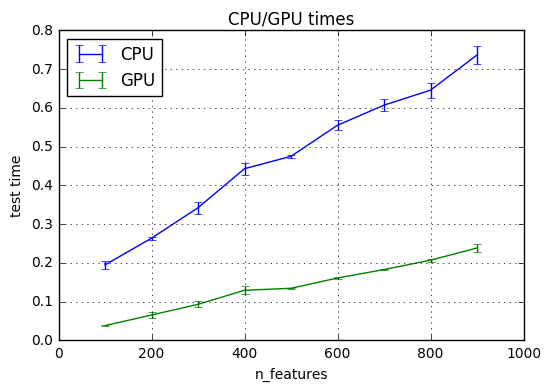

In [13]:
%pylab inline
errorbar(used_features, elapsed_mean['cpu'], yerr=elapsed_std['cpu'], label='CPU')
errorbar(used_features, elapsed_mean['gpu'], yerr=elapsed_std['gpu'], label='GPU')
xlim(0, 1000)
title('CPU/GPU times')
xlabel('n_features')
ylabel('test time')
legend(loc="upper left")
grid()